########################################################################################################################
              
              NOTEBOOK CRIADO PARA ANÁLISE DE DADOS E GERAÇÃO DO MODELO  - BOMBA CENTRIFUGA - PUMP01
    
    O escopo deste trabalho é:
    1 - Analisar os dados de um processo de bombeamento de polpa de minério;
    2 - Criar um modelo de machine learnig que possa estimar a vazão volumétrica da bomba;
    3 - Comparar este modelo com a vazão real, de modo a validar sua eficácia;
    
########################################################################################################################

########################################################################################################################

                                         IMPORT DE BIBLIOTECAS E DEFINIÇÃO DE FUNÇÕES 
                                         
########################################################################################################################

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import math
%matplotlib inline
import operator
import datetime
import time

In [12]:
def half_corr_htmp (df,title=None,file=None):
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style('white'):
        sns.heatmap(df.corr(), mask=mask, annot=True, cmap='coolwarm')
        
    if title: plt.title(f'\n{title}\n', fontsize=18)
    #plt.xlabel('')
    #plt.ylabel('')
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

In [13]:
def gen_histograms (df, cols=1, file=None):
    rows = math.ceil(len(df.columns)/cols)
    figwidth = 5*cols
    figheight = 4*rows
    
    fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize = (figwidth, figheight))
    
    color_choices = ['blue', 'grey', 'goldenrod', 'r', 'black', 'darkorange', 'g']
    ax = ax.ravel()      
    
        
    for i, column in enumerate (df.columns):
        ax[i].hist(df[column], 
                   color = color_choices[i%len(color_choices)],
                   alpha=1)
        ax[i].set_title(f'{df[column].name}', fontsize = 14)
        ax[i].set_ylabel('Observações', fontsize=14)
        ax[i].set_xlabel('', fontsize=14)
       
        
    fig.suptitle ('\nHistogramas para todas as variáveis', size = 18)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.88)
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

########################################################################################################################

                                 IMPORT E TRATAMENTO DO DATASET  DADOS DE PROCESSO - ORIGEM PIMS 
                                         
########################################################################################################################

In [14]:
dfPIMS = pd.read_csv("database_PIMS.csv", encoding = 'utf-8', sep=',', header='infer', low_memory=False)
dfPIMS.head(1)

,TimeStamp,Corrente,Temperatura Motor - 1,Temperatura Motor - 2,Temperatura Motor - 3,Temperatura Motor - 4,Temperatura Motor - 5,Pressão Água Selagem,Velocidade,Vazão
0,2020-07-01 00:01:00,202.566668,54.391281,52.244218,52.510209,39.975663,57.597589,4.745334,88.207194,539.719588


In [15]:
# INDEXA O DATAFRAME PELO TIMESTAMP

dfPIMS['TimeStamp'] = pd.to_datetime(dfPIMS['TimeStamp'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
dfPIMS.set_index(dfPIMS['TimeStamp'], inplace=True)
dfPIMS = dfPIMS.drop(['TimeStamp'], axis=1)
time = dfPIMS.index
dfPIMS.head(1)

,Corrente,Temperatura Motor - 1,Temperatura Motor - 2,Temperatura Motor - 3,Temperatura Motor - 4,Temperatura Motor - 5,Pressão Água Selagem,Velocidade,Vazão
TimeStamp,,,,,,,,,
2020-07-01 00:01:00,202.566668,54.391281,52.244218,52.510209,39.975663,57.597589,4.745334,88.207194,539.719588


In [16]:
dfPIMS.tail(1)

,Corrente,Temperatura Motor - 1,Temperatura Motor - 2,Temperatura Motor - 3,Temperatura Motor - 4,Temperatura Motor - 5,Pressão Água Selagem,Velocidade,Vazão
TimeStamp,,,,,,,,,
2020-07-31 23:59:00,205.103334,59.786093,57.647291,58.033537,44.795576,60.587001,3.59262,89.266866,568.379362


In [17]:
# VERIFICA TAMANHO DO DF

dfPIMS.shape

(44639, 9)

In [18]:
dfPIMS.dtypes

Corrente                 float64
Temperatura Motor - 1    float64
Temperatura Motor - 2    float64
Temperatura Motor - 3    float64
Temperatura Motor - 4    float64
Temperatura Motor - 5    float64
Pressão Água Selagem     float64
Velocidade               float64
Vazão                    float64
dtype: object

In [19]:
dfPIMS.isna().sum()

Corrente                 0
Temperatura Motor - 1    0
Temperatura Motor - 2    0
Temperatura Motor - 3    0
Temperatura Motor - 4    0
Temperatura Motor - 5    0
Pressão Água Selagem     0
Velocidade               0
Vazão                    0
dtype: int64

########################################################################################################################

                                                 ANÁLISE DESCRITIVA
                                         
########################################################################################################################

In [63]:
dfPIMS.describe()

,Corrente,Temperatura Motor - 1,Temperatura Motor - 2,Temperatura Motor - 3,Temperatura Motor - 4,Temperatura Motor - 5,Pressão Água Selagem,Velocidade,Vazão
count,44639.000000,44639.000000,44639.000000,44639.000000,44639.000000,44639.000000,44639.000000,44639.000000,44639.000000
mean,200.176522,59.734016,57.676255,57.909518,45.807491,60.366097,4.166340,87.944792,547.234843
std,17.495619,2.908092,2.885385,2.866582,2.800307,2.167664,0.370112,7.199546,46.243240
min,0.000000,41.494195,40.194425,40.628023,33.746103,41.211387,2.959580,0.000000,0.045281
25%,199.034667,58.187694,56.097784,56.295193,43.893072,59.173143,3.904089,87.887535,541.308408
50%,201.915001,59.978970,57.900924,58.155306,45.845823,60.637759,4.134630,88.475342,551.896473
75%,205.084750,61.751846,59.693759,59.904387,47.755453,61.788006,4.342108,89.194499,560.136786
max,223.359167,65.754660,63.702449,63.987701,57.165440,64.500093,5.236806,92.543864,607.744714


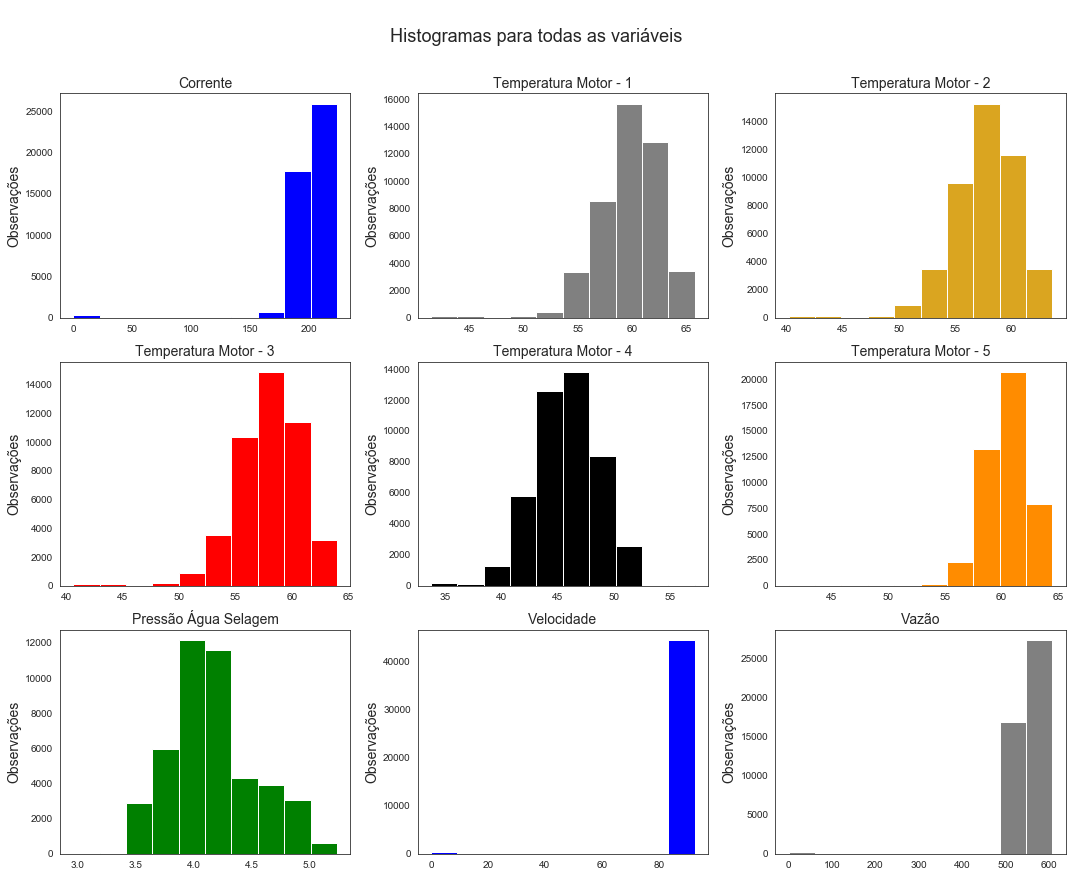

In [21]:
# VERIFICA VISUALMENTE A DISTRIBUIÇÃO DA AMOSTRA

gen_histograms(dfPIMS,3)

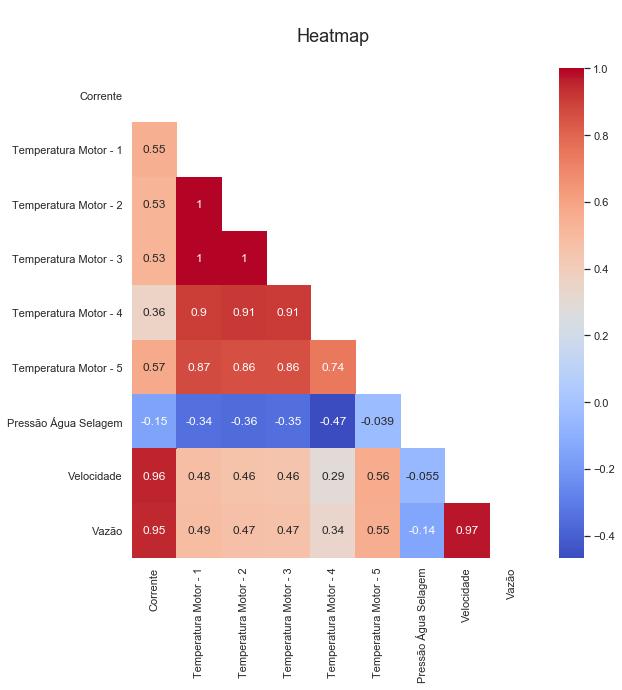

In [22]:
half_corr_htmp(dfPIMS, 'Heatmap')

########################################################################################################################

                                                 EXECUÇÃO DO MODELO
                                         
########################################################################################################################

In [23]:
# SEPARA VARIÁVEIS ESCOLHIDAS
cols=['Velocidade','Corrente','Vazão']
dfreg = dfPIMS[cols]
dfreg.head(1)

,Velocidade,Corrente,Vazão
TimeStamp,,,
2020-07-01 00:01:00,88.207194,202.566668,539.719588


In [37]:
# VARIÁVEIS DEPENDENTE E INDEPENDENTES

X = dfreg.drop("Vazão",1)   # INDEPENDENTES
y = dfreg["Vazão"]          # DEPENDENTE

In [38]:
# DIVIDE A BASE DE DADOS EM TREINO E VALIDAÇÃO

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, train_size = 0.7, random_state = 0)
X = Xtrain.iloc[:,:].values
y = ytrain.values

In [39]:
# COMO IREMOS UTILIZAR REGRESSÃO LINEAR MULTIPLA,
# PRECISAMOS ACRESCENTAR A COLUNA DE TERMO CONSTANTE (b0) NA MATRIZ - Y = b0+b1x1+b2x2+...+bnxn

X = sm.add_constant(X)

In [40]:
# EXECUTA A REGRESSÃO NA BASE DE TREINO E PRINTA O RESULTADO DO MODELO

reg = sm.OLS(y, X)
mdl = reg.fit()
print(mdl.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 2.913e+05
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:07:34   Log-Likelihood:            -1.1705e+05
No. Observations:               31247   AIC:                         2.341e+05
Df Residuals:                   31244   BIC:                         2.341e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9984      0.725      2.756      0.0

########################################################################################################################

                                                MÉTRICAS DE TREINO E TESTE
                                         
########################################################################################################################

In [41]:
# PEGA OS VALORES DAS FEATURES DA BASE DE TESTE E ADICIONA A COLUNA b0 DA REGRESSÃO
Xtest = Xtest.iloc[:,:].values
Xtest = sm.add_constant(Xtest)

In [42]:
# CALCULA VAZÃO PREDITA COM BASE NO MODELO
ypred = mdl.predict(Xtest)

In [43]:
# CALCULA ERROS MAE E RMSE - SCIKITLEARN

train_error = mean_absolute_error(ytrain, mdl.predict(X))
test_error = mean_absolute_error(ytest, mdl.predict(Xtest))
rmse_train_error = math.sqrt(mean_squared_error(ytrain, mdl.predict(X)))
rmse_val_error = math.sqrt(mean_squared_error(ytest, mdl.predict(Xtest)))

print('MAE do treino:', '%.2f' %train_error)
print('MAE do teste:' , '%.2f' %test_error)
print('RMSE do treino:', '%.2f' %rmse_train_error)
print('RMSE do teste:' , '%.2f' %rmse_val_error)

MAE do treino: 8.06
MAE do teste: 7.99
RMSE do treino: 10.25
RMSE do teste: 10.44


### CALCULADO O MODELO E VALIDADO O MESMO NA BASE DE TESTE, FOI CONSTATADO A ADERÊNCIA DO MODELO, DE ACORDO COM AS MÉTRICAS:

#### ERRO ABSOLUTO MÉDIO: 7,99 m³/h;
#### ERRO MÉDIO QUADRÁTICO: 10,44 m³/h;

########################################################################################################################

                                         VALIDAÇÃO DO MODELO 
                                         
########################################################################################################################

########################################################################################################################

                             IMPORT E TRATAMENTO DO DATASET  DADOS DE PROCESSO  - ORIGEM SCADA 
                                         
########################################################################################################################

In [44]:
dfSCADA = pd.read_csv("database_SCADA.csv", encoding = 'utf-8', sep = ';', header='infer', low_memory=False)
dfSCADA.head(1)

,TimeStamp,Corrente,Temperatura Motor - 1,Temperatura Motor - 2,Temperatura Motor - 3,Temperatura Motor - 4,Temperatura Motor - 5,Pressão Água Selagem,Velocidade,Vazão
0,01/09/2020 00:01,0,"45,19256187","43,93864853","44,4699717","37,93784457","44,28255739","3,927822043",0,"0,161801147"


In [45]:
# INDEXA O DATAFRAME PELO TIMESTAMP

dfSCADA['TimeStamp'] = pd.to_datetime(dfSCADA['TimeStamp'], format = '%d/%m/%Y %H:%M', errors = 'coerce')
dfSCADA.set_index(dfSCADA['TimeStamp'], inplace=True)
dfSCADA = dfSCADA.drop(['TimeStamp'], axis=1)
time = dfSCADA.index
dfSCADA.head(1)

,Corrente,Temperatura Motor - 1,Temperatura Motor - 2,Temperatura Motor - 3,Temperatura Motor - 4,Temperatura Motor - 5,Pressão Água Selagem,Velocidade,Vazão
TimeStamp,,,,,,,,,
2020-09-01 00:01:00,0,"45,19256187","43,93864853","44,4699717","37,93784457","44,28255739","3,927822043",0,"0,161801147"


In [46]:
dfSCADA.tail(1)

,Corrente,Temperatura Motor - 1,Temperatura Motor - 2,Temperatura Motor - 3,Temperatura Motor - 4,Temperatura Motor - 5,Pressão Água Selagem,Velocidade,Vazão
TimeStamp,,,,,,,,,
2020-12-31 23:59:00,0,"35,16790867","33,85769412","34,57715273","29,93698953","32,65043945","-0,008429323",0,"0,147356669"


In [47]:
dfSCADA.shape

(175679, 9)

In [48]:
dfSCADA.dtypes

Corrente                 object
Temperatura Motor - 1    object
Temperatura Motor - 2    object
Temperatura Motor - 3    object
Temperatura Motor - 4    object
Temperatura Motor - 5    object
Pressão Água Selagem     object
Velocidade               object
Vazão                    object
dtype: object

In [49]:
dfSCADA.isna().sum()

Corrente                 0
Temperatura Motor - 1    0
Temperatura Motor - 2    0
Temperatura Motor - 3    0
Temperatura Motor - 4    0
Temperatura Motor - 5    0
Pressão Água Selagem     0
Velocidade               0
Vazão                    0
dtype: int64

In [50]:
# CONVERSÃO PARA NUMÉRICOS 

collist = []
for col in dfSCADA:
    collist.append(col)

for i in range(len(collist)):
    dfSCADA[collist[i]] = dfSCADA[collist[i]].str.replace(',','.')
    
    
collist = []
for col in dfSCADA:
    collist.append(col)

for i in range(len(collist)):
    dfSCADA[collist[i]] = pd.to_numeric(dfSCADA[collist[i]], errors = 'coerce')


In [51]:
dfSCADA.dtypes

Corrente                 float64
Temperatura Motor - 1    float64
Temperatura Motor - 2    float64
Temperatura Motor - 3    float64
Temperatura Motor - 4    float64
Temperatura Motor - 5    float64
Pressão Água Selagem     float64
Velocidade               float64
Vazão                    float64
dtype: object

In [52]:
dfSCADA.isna().sum()

Corrente                 470
Temperatura Motor - 1    471
Temperatura Motor - 2    471
Temperatura Motor - 3    471
Temperatura Motor - 4    471
Temperatura Motor - 5    471
Pressão Água Selagem     470
Velocidade               470
Vazão                    470
dtype: int64

In [53]:
# EXCLUI LINHAS COM NaN
dfSCADA = dfSCADA.dropna()

In [54]:
dfSCADA.isna().sum()

Corrente                 0
Temperatura Motor - 1    0
Temperatura Motor - 2    0
Temperatura Motor - 3    0
Temperatura Motor - 4    0
Temperatura Motor - 5    0
Pressão Água Selagem     0
Velocidade               0
Vazão                    0
dtype: int64

########################################################################################################################

                                         APLICAÇÃO DO MODELO NA BASE DE VALIDAÇÃO
                                         
########################################################################################################################

In [55]:
# SEPARA VARIÁVEIS ESCOLHIDAS
dfval = dfSCADA[['Velocidade','Corrente','Vazão']]

In [56]:
# APLICA REGRESSÃO E INSERE NO dfval
dfval.insert(3, 'Vazão Calculada', (mdl.params[0] + mdl.params[1]*(dfval['Velocidade']) + mdl.params[2]*(dfval['Corrente'])))

In [57]:
dfval.head(1) 

,Velocidade,Corrente,Vazão,Vazão Calculada
TimeStamp,,,,
2020-09-01 00:01:00,0.0,0.0,0.161801,1.998399


In [58]:
# CALCULA ERROS MAE E RMSE - SCIKITLEARN

val_error = mean_absolute_error(dfval['Vazão'].values,dfval['Vazão Calculada'].values)
rmse_val_error = math.sqrt(mean_squared_error(dfval['Vazão'].values,dfval['Vazão Calculada'].values))

print('MAE da validação:', '%.2f' %val_error)
print('RMSE da validação:' , '%.2f' %rmse_val_error)

MAE da validação: 9.51
RMSE da validação: 16.53


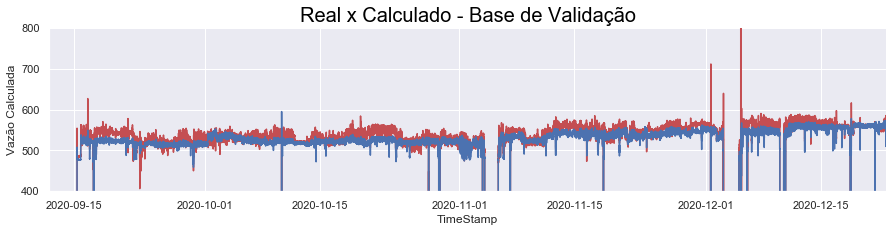

In [74]:
# PLOTA GRAFICO DE TENDENCIA

fig1,ax1 = plt.subplots(figsize = (15,3))
sns.set_palette('deep')
sns.set_style('darkgrid')
plt.title("Real x Calculado - Base de Validação", fontsize=20, color = 'black')
ax1 = sns.lineplot(x=dfval.index, y=dfval['Vazão'], color = 'r')
ax1 = sns.lineplot(x=dfval.index, y=dfval['Vazão Calculada'])
ax1.set(xlim=(datetime.date(2020, 9, 12),datetime.date(2020, 12, 23)))
ax1.set(ylim=(400,800))
sns.despine()

In [75]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
